# Preliminary info:
- Data comes pre-split into train test, however the test set only contains one instance of each class
- There are 29 subdirectories in the train set, 3 of which are nonalpha 
- We'll also disregard J and Z since they require movement to sign
- Train set: 87,000 images which are 200x200 pixels
- Test set: 29 images same reso
- Need to think about having an 'other' class

In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import os

RANDOM_SEED = 21223

In [11]:
from zipfile import ZipFile
dir_path = "../data"
train_path = dir_path + "/asl_train"
test_path = dir_path + "/asl_test"

def unzip_if_not_exists(zip_file_path, extract_to_path):
    # check if the target directory already exists
    if not os.path.exists(extract_to_path):
        # create the directory if it doesn't exist
        os.makedirs(extract_to_path)
        # unzip the contents
        with ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_path)
        print(f"Successfully unzipped to {extract_to_path}")
    else:
        print(f"The directory {extract_to_path} already exists. Skipped unzipping.")

unzip_if_not_exists(dir_path + "/asl_alphabet_train.zip", train_path)
unzip_if_not_exists(dir_path + "/asl_alphabet_test.zip", test_path)

The directory ../data/asl_train already exists. Skipped unzipping.
The directory ../data/asl_test already exists. Skipped unzipping.


In [12]:
train_path += "/asl_alphabet_train/"
test_path += "/asl_alphabet_test/"

# map alphabet to numbers
categories = {  0: "A",
                1: "B",
                2: "C",
                3: "D",
                4: "E",
                5: "F",
                6: "G",
                7: "H",
                8: "I",
                9: "G",
                10: "K",
                11: "L",
                12: "M",
                13: "N",
                14: "O",
                15: "P",
                16: "Q",
                17: "R",
                18: "S",
                19: "T",
                20: "U",
                21: "V",
                22: "W",
                23: "X",
                24: "Y",
            }

def add_class_name_prefix(df, col_name):
    df[col_name]
    return df

# store all the file names in the dataset
filenames = []
# store the corresponding class for each file
target = []

for category in categories:
    files = os.listdir(train_path + categories[category])
    filenames += files
    target += [category] * len(files)

df = pd.DataFrame({"filename": filenames, "category": target})
df = add_class_name_prefix(df, "filename")

# shuffle the dataframe
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

In [13]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  75000 non-null  object
 1   category  75000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


,filename,category
0,R1996.jpg,17
1,L2770.jpg,11
2,N1031.jpg,13
3,L1673.jpg,11
4,V1186.jpg,21


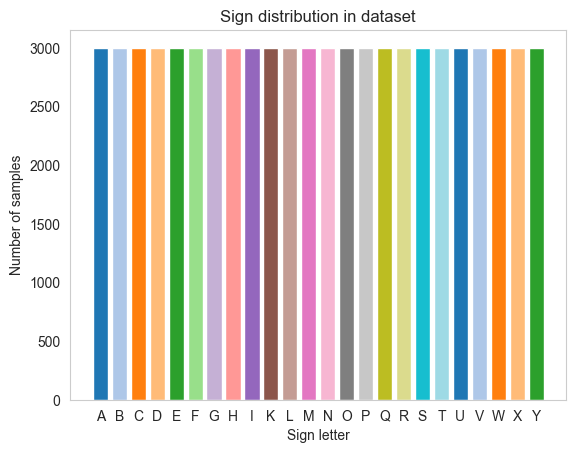

In [14]:
# plot class distribution
unique_labels, counts = np.unique(df['category'], return_counts=True)

cmap = plt.get_cmap("tab20")

plt.bar(list(categories.values()), counts, color=cmap.colors)
plt.xlabel('Sign letter')
plt.ylabel('Number of samples')
plt.title('Sign distribution in dataset')
plt.grid(False)
plt.show()

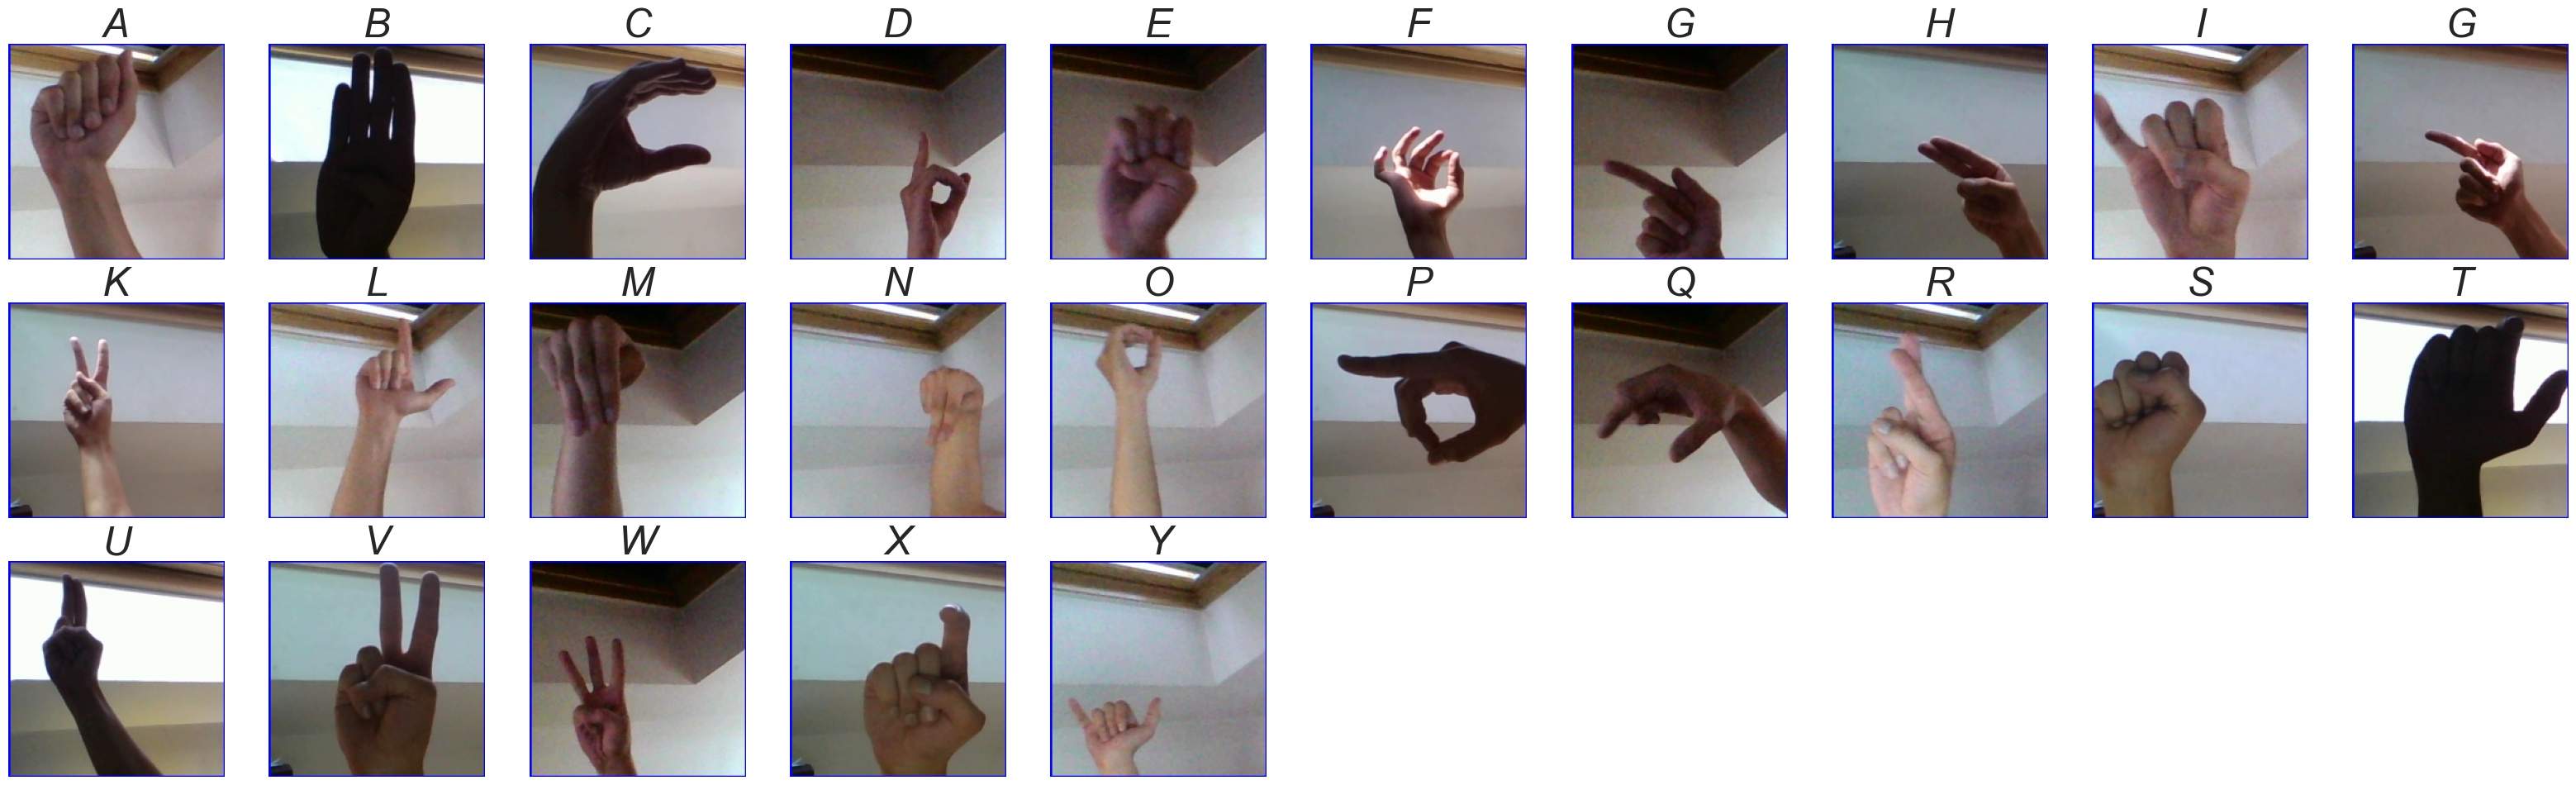

In [15]:
# plot a few example images

plt.figure(figsize=(40,40))

for i in range(25):
    img_names = df.loc[df["category"]==i]
    img_name = img_names.sample(ignore_index=True, random_state=RANDOM_SEED).filename[0]
    path = ""
    path = train_path + categories[i] + "/" + img_name
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[i],fontsize=35,fontstyle='italic')
    plt.axis("off")

# Attempting some low dim visualization

In [16]:
# i could not get cv2 to work in pipenv
#import cv2
#
# image to numbers
#def process_row(row):
#    filename = row["filename"]
#    label = row["category"]
#    # load
#    image = cv2.imread(train_path + "/" + categories[label] + "/" + filename)
#    # convert to grayscale
#    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#    # flatten 2d tensor to 1d array
#    flat_image = gray_image.ravel()
#    
#    new_row = pd.DataFrame({'image_array': [flat_image], 'label': label})
#    return new_row
#
#df.apply(process_row, axis=1, result_type="expand")

ValueError: If using all scalar values, you must pass an index

In [17]:
from PIL import Image

# image to numbers
def process_row(row):
    filename = row["filename"]
    label = row["category"]
    # load
    image = Image.open(train_path + "/" + categories[label] + "/" + filename)
    # convert to grayscale
    gray_image = image.convert('L')
    # convert to 2d tensor
    image_array = np.array(gray_image)
    # flatten 2d tensor to 1d array
    flat_image = image_array.ravel()
    new_row = {'image_array': flat_image, 'label': label}
    return new_row

result_df = df[0:1000].apply(process_row, axis=1, result_type="expand")

In [18]:
result_df.head()

,image_array,label
0,"[30, 32, 28, 31, 30, 30, 30, 30, 28, 30, 29, 3...",17
1,"[32, 32, 28, 28, 32, 28, 30, 30, 28, 29, 29, 2...",11
2,"[29, 32, 29, 30, 32, 28, 29, 29, 30, 29, 28, 2...",13
3,"[32, 32, 29, 30, 29, 30, 27, 32, 29, 30, 30, 2...",11
4,"[30, 30, 29, 29, 29, 29, 28, 31, 29, 29, 27, 2...",21


In [19]:
# convert 'image_array' to separate columns
image_columns = pd.DataFrame(result_df['image_array'].apply(pd.Series).values, columns=[f'pixel_{i}' for i in range(len(result_df['image_array'].iloc[0]))])

image_columns.head()
image_columns.describe()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_39990,pixel_39991,pixel_39992,pixel_39993,pixel_39994,pixel_39995,pixel_39996,pixel_39997,pixel_39998,pixel_39999
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000
mean,30.476000,31.098000,29.07400,29.815000,29.456000,29.698000,28.790000,29.454000,29.268000,29.229000,...,28.951000,28.937000,28.79000,29.086000,28.773000,28.87600,29.272000,28.675000,29.05700,29.11300
std,1.281822,1.680244,1.17128,1.205084,1.091446,1.252344,1.225317,1.016325,0.806738,0.755732,...,0.518525,0.676379,1.15379,1.792712,1.379628,1.50562,1.304499,1.412576,1.72009,1.21561
min,28.000000,27.000000,27.00000,27.000000,27.000000,27.000000,26.000000,27.000000,27.000000,27.000000,...,27.000000,27.000000,25.00000,23.000000,25.000000,24.00000,25.000000,25.000000,24.00000,25.00000
25%,30.000000,30.000000,28.00000,29.000000,29.000000,29.000000,28.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,28.00000,28.000000,28.000000,28.00000,28.000000,28.000000,28.00000,28.00000
50%,30.000000,31.000000,29.00000,30.000000,29.000000,30.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.00000,29.000000,29.000000,29.00000,29.000000,29.000000,29.00000,29.00000
75%,31.000000,32.000000,30.00000,31.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,29.000000,29.000000,30.00000,30.000000,30.000000,30.00000,30.000000,30.000000,30.00000,30.00000
max,34.000000,36.000000,33.00000,35.000000,33.000000,34.000000,34.000000,32.000000,32.000000,32.000000,...,31.000000,31.000000,33.00000,34.000000,33.000000,33.00000,33.000000,34.000000,34.00000,32.00000


In [37]:
x = np.array(image_columns.values)
print(x)
x_scaled = x / np.max(np.max(x))

scaled_df = pd.DataFrame(x_scaled)
scaled_df['label'] = result_df['label']

scaled_df.describe()

[[30 32 28 ... 27 32 29]
 [32 32 28 ... 31 28 31]
 [29 32 29 ... 29 28 29]
 ...
 [31 32 32 ... 26 28 30]
 [30 32 29 ... 28 32 26]
 [29 33 28 ... 29 30 29]]


,0,1,2,3,4,5,6,7,8,9,...,39991,39992,39993,39994,39995,39996,39997,39998,39999,label
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.119514,0.121953,0.114016,0.116922,0.115514,0.116463,0.112902,0.115506,0.114776,0.114624,...,0.113478,0.112902,0.114063,0.112835,0.113239,0.114792,0.112451,0.113949,0.114169,11.762000
std,0.005027,0.006589,0.004593,0.004726,0.004280,0.004911,0.004805,0.003986,0.003164,0.002964,...,0.002652,0.004525,0.007030,0.005410,0.005904,0.005116,0.005540,0.006745,0.004767,7.182266
min,0.109804,0.105882,0.105882,0.105882,0.105882,0.105882,0.101961,0.105882,0.105882,0.105882,...,0.105882,0.098039,0.090196,0.098039,0.094118,0.098039,0.098039,0.094118,0.098039,0.000000
25%,0.117647,0.117647,0.109804,0.113725,0.113725,0.113725,0.109804,0.113725,0.113725,0.113725,...,0.113725,0.109804,0.109804,0.109804,0.109804,0.109804,0.109804,0.109804,0.109804,5.000000
50%,0.117647,0.121569,0.113725,0.117647,0.113725,0.117647,0.113725,0.113725,0.113725,0.113725,...,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,0.113725,12.000000
75%,0.121569,0.125490,0.117647,0.121569,0.117647,0.117647,0.117647,0.117647,0.117647,0.117647,...,0.113725,0.117647,0.117647,0.117647,0.117647,0.117647,0.117647,0.117647,0.117647,18.000000
max,0.133333,0.141176,0.129412,0.137255,0.129412,0.133333,0.133333,0.125490,0.125490,0.125490,...,0.121569,0.129412,0.133333,0.129412,0.129412,0.129412,0.133333,0.133333,0.125490,24.000000


In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

pixels = scaled_df.drop('label', axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pixels)

pca_df = pd.DataFrame() 
pca_df['pca-one'] = pca_result[:,0]
pca_df['pca-two'] = pca_result[:,1] 
pca_df['label'] = scaled_df['label']

/var/folders/x1/dl1z_tcs7zb6pppfbf65d5sh0000gn/T/ipykernel_54631/2132784542.py:2: UserWarning: 
The palette list has fewer values (24) than needed (25) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


<Axes: xlabel='pca-one', ylabel='pca-two'>

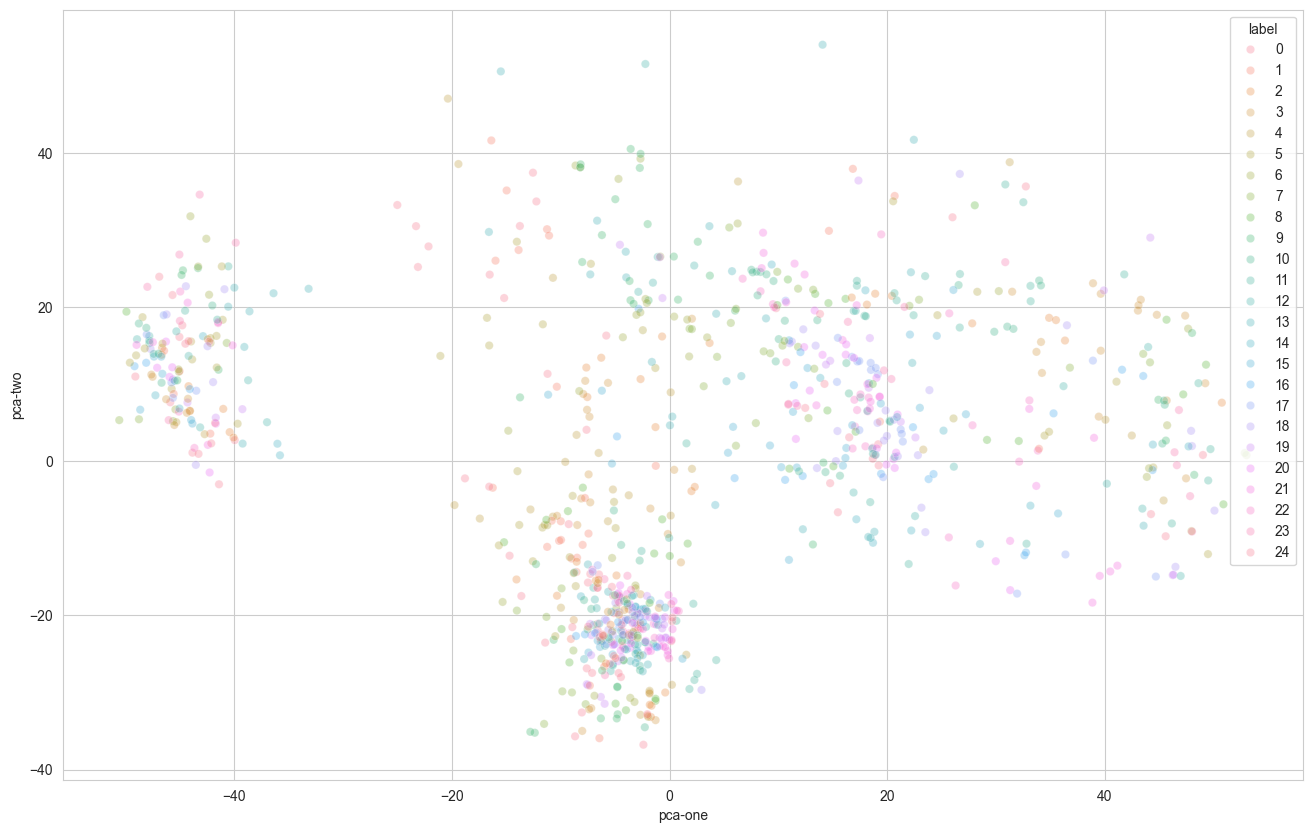

In [42]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="label",
    palette=sns.color_palette("husl", 24),
    data=pca_df,
    legend="full",
    alpha=0.3
)